# Experimental: TF Autograph
**TensorFlow Dev Summit, 2018.**

This interactive notebook demonstrates **autograph**, an experimental source-code transformation library to automatically convert TF.Eager and Python code to TensorFlow graphs.

**Note: this is pre-alpha software!** The notebook works best with Python 2, for now.

> ![alt text](https://lh3.googleusercontent.com/QOvy0clmg7siaVKzwmSPAjicWWNQ0OeyaB16plDjSJMf35WD3vLjF6mz4CGrhSHw60HnlZPJjkyDCBzw5XOI0oBGSewyYw=s688)

### Table of Contents
1. _Write Eager code that is fast and scalable._
2. _Case study: complex control flow._
3. _Case study: training MNIST with Keras._
4. _Case study: building an RNN._

In [0]:
# Install TensorFlow; note that Colab notebooks run remotely, on virtual
# instances provided by Google.
!pip install -U -q tf-nightly

In [0]:
import os
import time

import tensorflow as tf
from tensorflow.contrib import autograph

import matplotlib.pyplot as plt
import numpy as np
import six

from google.colab import widgets

# 1. Write Eager code that is fast and scalable

TF.Eager gives you more flexibility while coding, but at the cost of losing the benefits of TensorFlow graphs. For example, Eager does not currently support distributed training, exporting models, and a variety of memory and computation optimizations.

Autograph gives you the best of both worlds: write your code in an Eager style, and we will automatically transform it into the equivalent TF graph code. The graph code can be executed eagerly (as a single op), included as part of a larger graph, or exported.

For example, autograph can convert a function like this:

In [0]:
def g(x):
  if x > 0:
    x = x * x
  else:
    x = 0
  return x

... into a TF graph-building function:

In [4]:
print(autograph.to_code(g))

from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.autograph.impl import api as autograph_api
from tensorflow.contrib.autograph import utils as autograph_utils

def tf__g(x):
  with tf.name_scope('g'):

    def if_true():
      with tf.name_scope('if_true'):
        x_1, = x,
        x_1 = x_1 * x_1
        return x_1,

    def if_false():
      with tf.name_scope('if_false'):
        x_1, = x,
        x_1 = 0
        return x_1,
    x = autograph_utils.run_cond(tf.greater(x, 0), if_true, if_false)
    return x



You can then use the converted function as you would any regular TF op -- you can pass `Tensor` arguments and it will return `Tensor`s:

In [5]:
tf_g = autograph.to_graph(g)

with tf.Graph().as_default():  

  g_ops = tf_g(tf.constant(9))

  with tf.Session() as sess:
    tf_g_result = sess.run(g_ops)

  print('g(9) = %s' % g(9))
  print('tf_g(9) = %s' % tf_g_result)

g(9) = 81
tf_g(9) = 81


# 2. Case study: complex control flow

Autograph can convert a large chunk of the Python language into graph-equivalent code, and we're adding new supported language features all the time. In this section, we'll give you a taste of some of the functionality in autograph.
Autograph will automatically convert most Python control flow statements into their correct graph equivalent.
  

We support common statements like `while`, `for`, `if`, `break`, `return` and more. You can even nest them as much as you like. Imagine trying to write the graph version of this code by hand:

In [6]:
def sum_even(numbers):
  s = 0
  for n in numbers:
    if n % 2 > 0:
      continue
    s += n
  return s


tf_sum_even = autograph.to_graph(sum_even)

with tf.Graph().as_default():  
  with tf.Session() as sess:
    result = sess.run(tf_sum_even(tf.constant([10, 12, 15, 20])))

  print('Sum of even numbers: %s' % result)

Sum of even numbers: 42


Try replacing the `continue` in the above code with `break` -- Autograph supports that as well!

The Python code above is much more readable than the matching graph code. Autograph takes care of tediously converting every piece of Python code into the matching TensorFlow graph version for you, so that you can quickly write maintainable code, but still benefit from the optimizations and deployment benefits of graphs.

Let's try some other useful Python constructs, like `print` and `assert`. We automatically convert Python `assert` statements into the equivalent `tf.Assert` code.  

In [7]:
def f(x):
  assert x != 0, 'Do not pass zero!'
  return x * x

tf_f = autograph.to_graph(f)
with tf.Graph().as_default():  
  with tf.Session() as sess:
    try:
      print(sess.run(tf_f(tf.constant(0))))
    except tf.errors.InvalidArgumentError as e:
      print('Got error message: %s' % e.message)

Got error message: assertion failed: [Do not pass zero!]
	 [[Node: f/Assert/Assert = Assert[T=[DT_STRING], summarize=3, _device="/job:localhost/replica:0/task:0/device:CPU:0"](f/NotEqual, f/Assert/Assert/data_0)]]


You can also use `print` functions in-graph:

In [8]:
def print_sign(n):
  if n >= 0:
    print(n, 'is positive!')
  else:
    print(n, 'is negative!')
  return n


tf_print_sign = autograph.to_graph(print_sign)
with tf.Graph().as_default():
  with tf.Session() as sess:
    sess.run(tf_print_sign(tf.constant(1)))

1 is positive!


We can convert lists to TensorArray, so appending to lists also works, with a few modifications:

In [9]:
def f(n):
  numbers = []
  # We ask you to tell us about the element dtype.
  autograph.utils.set_element_type(numbers, tf.int32)
  for i in range(n):
    numbers.append(i)
  return numbers.stack() # Stack the list so that it can be used as a Tensor


tf_f = autograph.to_graph(f)
with tf.Graph().as_default():
  with tf.Session() as sess:
    print(sess.run(tf_f(tf.constant(5))))

[0 1 2 3 4]


And all of these functionalities, and more, can be composed into more complicated code:


In [10]:
def print_primes(n):
  """Returns all the prime numbers less than n."""
  assert n > 0
  
  primes = []
  autograph.utils.set_element_type(primes, tf.int32)
  for i in range(2, n):
    is_prime = True
    for k in range(2, i):
      if i % k == 0:
        is_prime = False
        break
    if not is_prime:
      continue
    primes.append(i)
  all_primes = primes.stack()

  print('The prime numbers less than', n, 'are:')
  print(all_primes)
  return tf.no_op()

    
tf_print_primes = autograph.to_graph(print_primes)
with tf.Graph().as_default():  
  with tf.Session() as sess:
    n = tf.constant(50)
    sess.run(tf_print_primes(n))

The prime numbers less than 50 are:
[ 2  3  5  7 11 13 17 19 23 29 31 37 41 43 47]


# 3. Case study: training MNIST with Keras

As we've seen, writing control flow in Autograph is easy. So running a training loop in graph should be easy as well!

Here, we show an example of such a training loop for a simple Keras model that trains on MNIST.

In [0]:
import gzip
import shutil

from six.moves import urllib


def download(directory, filename):
  filepath = os.path.join(directory, filename)
  if tf.gfile.Exists(filepath):
    return filepath
  if not tf.gfile.Exists(directory):
    tf.gfile.MakeDirs(directory)
  url = 'https://storage.googleapis.com/cvdf-datasets/mnist/' + filename + '.gz'
  zipped_filepath = filepath + '.gz'
  print('Downloading %s to %s' % (url, zipped_filepath))
  urllib.request.urlretrieve(url, zipped_filepath)
  with gzip.open(zipped_filepath, 'rb') as f_in, open(filepath, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)
  os.remove(zipped_filepath)
  return filepath


def dataset(directory, images_file, labels_file):
  images_file = download(directory, images_file)
  labels_file = download(directory, labels_file)

  def decode_image(image):
    # Normalize from [0, 255] to [0.0, 1.0]
    image = tf.decode_raw(image, tf.uint8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [784])
    return image / 255.0

  def decode_label(label):
    label = tf.decode_raw(label, tf.uint8)
    label = tf.reshape(label, [])
    return tf.to_int32(label)

  images = tf.data.FixedLengthRecordDataset(
      images_file, 28 * 28, header_bytes=16).map(decode_image)
  labels = tf.data.FixedLengthRecordDataset(
      labels_file, 1, header_bytes=8).map(decode_label)
  return tf.data.Dataset.zip((images, labels))


def mnist_train(directory):
  return dataset(directory, 'train-images-idx3-ubyte',
                 'train-labels-idx1-ubyte')

def mnist_test(directory):
  return dataset(directory, 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte')

First, we'll define a small three-layer neural network using the Keras API

In [0]:
def mlp_model(input_shape):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(100, activation='relu', input_shape=input_shape),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')])
  model.build()
  return model

Let's connect the model definition (here abbreviated as `m`) to a loss function, so that we can train our model.

In [0]:
def predict(m, x, y):
  y_p = m(x)
  losses = tf.keras.losses.categorical_crossentropy(y, y_p)
  l = tf.reduce_mean(losses)
  accuracies = tf.keras.metrics.categorical_accuracy(y, y_p)
  accuracy = tf.reduce_mean(accuracies)
  return l, accuracy

Now the final piece of the problem specification (before loading data, and clicking everything together) is backpropagating the loss through the model, and optimizing the weights using the gradient.

In [0]:
def fit(m, x, y, opt):
  l, accuracy = predict(m, x, y)
  opt.minimize(l)
  return l, accuracy

These are some utility functions to download data and generate batches for training

In [0]:
def setup_mnist_data(is_training, hp, batch_size):
  if is_training:
    ds = mnist_train('/tmp/autograph_mnist_data')
    ds = ds.shuffle(batch_size * 10)
  else:
    ds = mnist_test('/tmp/autograph_mnist_data')
  ds = ds.repeat()
  ds = ds.batch(batch_size)
  return ds

def get_next_batch(ds):
  itr = ds.make_one_shot_iterator()
  image, label = itr.get_next()
  x = tf.to_float(tf.reshape(image, (-1, 28 * 28)))
  y = tf.one_hot(tf.squeeze(label), 10)
  return x, y

This function specifies the main training loop. We instantiate the model (using the code above), instantiate an optimizer (here we'll use SGD with momentum, nothing too fancy), and we'll instantiate some lists to keep track of training and test loss and accuracy over time.

In the loop inside this function, we'll grab a batch of data, apply an update to the weights of our model to improve its performance, and then record its current training loss and accuracy. Every so often, we'll log some information about training as well.

In [0]:
def train(train_ds, test_ds, hp):
  m = mlp_model((28 * 28,))
  opt = tf.train.MomentumOptimizer(hp.learning_rate, 0.9)
  train_losses = []
  train_losses = autograph.utils.set_element_type(train_losses, tf.float32)
  test_losses = []
  test_losses = autograph.utils.set_element_type(test_losses, tf.float32)
  train_accuracies = []
  train_accuracies = autograph.utils.set_element_type(train_accuracies,
                                                      tf.float32)
  test_accuracies = []
  test_accuracies = autograph.utils.set_element_type(test_accuracies,
                                                     tf.float32)
  i = tf.constant(0)
  while i < hp.max_steps:
    train_x, train_y = get_next_batch(train_ds)
    test_x, test_y = get_next_batch(test_ds)
    step_train_loss, step_train_accuracy = fit(m, train_x, train_y, opt)
    step_test_loss, step_test_accuracy = predict(m, test_x, test_y)
    if i % (hp.max_steps // 10) == 0:
      print('Step', i, 'train loss:', step_train_loss, 'test loss:',
            step_test_loss, 'train accuracy:', step_train_accuracy,
            'test accuracy:', step_test_accuracy)
    train_losses.append(step_train_loss)
    test_losses.append(step_test_loss)
    train_accuracies.append(step_train_accuracy)
    test_accuracies.append(step_test_accuracy)
    i += 1
  return (train_losses.stack(), test_losses.stack(),  train_accuracies.stack(),
          test_accuracies.stack())

Everything is ready to go, let's train the model and plot its performance!

Step 0 train loss: 2.244329 test loss: 2.2499208 train accuracy: 0.12 test accuracy: 0.161
Step 50 train loss: 0.64771986 test loss: 0.56013924 train accuracy: 0.82 test accuracy: 0.836
Step 100 train loss: 0.49011207 test loss: 0.42143965 train accuracy: 0.84 test accuracy: 0.879
Step 150 train loss: 0.3768609 test loss: 0.39319593 train accuracy: 0.88 test accuracy: 0.883
Step 200 train loss: 0.36007702 test loss: 0.37089333 train accuracy: 0.9 test accuracy: 0.881
Step 250 train loss: 0.182115 test loss: 0.28543878 train accuracy: 0.94 test accuracy: 0.915
Step 300 train loss: 0.2119576 test loss: 0.22305593 train accuracy: 0.92 test accuracy: 0.93
Step 350 train loss: 0.12932214 test loss: 0.29057172 train accuracy: 0.96 test accuracy: 0.906
Step 400 train loss: 0.22937602 test loss: 0.2200287 train accuracy: 0.92 test accuracy: 0.925
Step 450 train loss: 0.23444137 test loss: 0.19857481 train accuracy: 0.94 test accuracy: 0.94


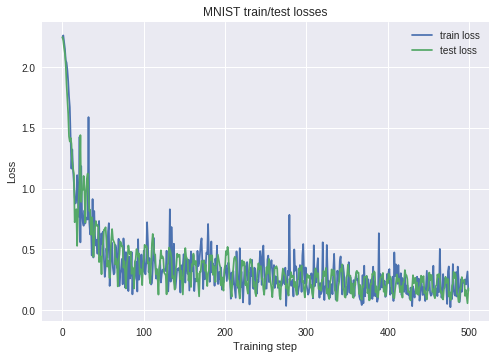

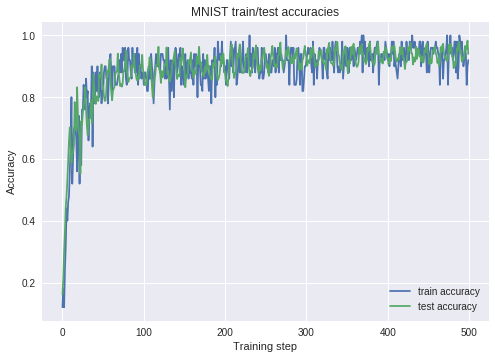

In [17]:
with tf.Graph().as_default():
  hp = tf.contrib.training.HParams(
      learning_rate=0.05,
      max_steps=500,
  )
  train_ds = setup_mnist_data(True, hp, 50)
  test_ds = setup_mnist_data(False, hp, 1000)
  tf_train = autograph.to_graph(train)
  (train_losses, test_losses, train_accuracies,
   test_accuracies) = tf_train(train_ds, test_ds, hp)

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    (train_losses, test_losses, train_accuracies,
     test_accuracies) = sess.run([train_losses, test_losses, train_accuracies,
                                  test_accuracies])
    plt.title('MNIST train/test losses')
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.xlabel('Training step')
    plt.ylabel('Loss')
    plt.show()
    plt.title('MNIST train/test accuracies')
    plt.plot(train_accuracies, label='train accuracy')
    plt.plot(test_accuracies, label='test accuracy')
    plt.legend(loc='lower right')
    plt.xlabel('Training step')
    plt.ylabel('Accuracy')
    plt.show()

# 4. Case study: building an RNN


In this exercise we build and train a model similar to the RNNColorbot model that was used in the main Eager notebook. The model is adapted for converting and training in graph mode.

To get started, we load the colorbot dataset. The code is identical to that used in the other exercise and its details are unimportant.

In [0]:
def parse(line):
  """Parses a line from the colors dataset.
  
  Args:
    line: A comma-separated string containing four items:
        color_name, red, green, and blue, representing the name and
        respectively the RGB value of the color, as an integer
        between 0 and 255.

  Returns:
    A tuple of three tensors (rgb, chars, length), of shapes: (batch_size, 3),
    (batch_size, max_sequence_length, 256) and respectively (batch_size).
  """
  items = tf.string_split([line], ",").values
  rgb = tf.string_to_number(items[1:], out_type=tf.float32) / 255.0
  color_name = items[0]
  chars = tf.one_hot(tf.decode_raw(color_name, tf.uint8), depth=256)
  length = tf.cast(tf.shape(chars)[0], dtype=tf.int64)
  return rgb, chars, length


def maybe_download(filename, work_directory, source_url):
  """Downloads the data from source url."""
  if not tf.gfile.Exists(work_directory):
    tf.gfile.MakeDirs(work_directory)
  filepath = os.path.join(work_directory, filename)
  if not tf.gfile.Exists(filepath):
    temp_file_name, _ = six.moves.urllib.request.urlretrieve(source_url)
    tf.gfile.Copy(temp_file_name, filepath)
    with tf.gfile.GFile(filepath) as f:
      size = f.size()
    print('Successfully downloaded', filename, size, 'bytes.')
  return filepath


def load_dataset(data_dir, url, batch_size, training=True):
  """Loads the colors data at path into a tf.PaddedDataset."""
  path = maybe_download(os.path.basename(url), data_dir, url)
  dataset = tf.data.TextLineDataset(path)
  dataset = dataset.skip(1)
  dataset = dataset.map(parse)
  dataset = dataset.cache()
  dataset = dataset.repeat()
  if training:
    dataset = dataset.shuffle(buffer_size=3000)
  dataset = dataset.padded_batch(batch_size, padded_shapes=([None], [None, None], []))
  return dataset


train_url = "https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/extras/colorbot/data/train.csv"
test_url = "https://raw.githubusercontent.com/random-forests/tensorflow-workshop/master/extras/colorbot/data/test.csv"
data_dir = "tmp/rnn/data"

Next, we set up the RNNColobot model, which is very similar to the one we used in the main exercise.

Autograph doesn't fully support classes yet (but it will soon!), so we'll write the model using simple functions.

In [0]:
def model_components():
  lower_cell = tf.contrib.rnn.LSTMBlockCell(256)
  lower_cell.build(tf.TensorShape((None, 256)))
  upper_cell = tf.contrib.rnn.LSTMBlockCell(128)
  upper_cell.build(tf.TensorShape((None, 256)))
  relu_layer = tf.layers.Dense(3, activation=tf.nn.relu)
  relu_layer.build(tf.TensorShape((None, 128)))
  return lower_cell, upper_cell, relu_layer


def rnn_layer(chars, cell, batch_size, training):
  """A simple RNN layer.
  
  Args:
    chars: A Tensor of shape (max_sequence_length, batch_size, input_size)
    cell: An object of type tf.contrib.rnn.LSTMBlockCell
    batch_size: Int, the batch size to use
    training: Boolean, whether the layer is used for training

  Returns:
    A Tensor of shape (max_sequence_length, batch_size, output_size).
  """
  hidden_outputs = []
  autograph.utils.set_element_type(hidden_outputs, tf.float32)
  state, output = cell.zero_state(batch_size, tf.float32)
  n = tf.shape(chars)[0]
  i = 0
  while i < n:
    ch = chars[i]
    cell_output, (state, output) = cell.call(ch, (state, output))
    hidden_outputs.append(cell_output)
    i += 1
  hidden_outputs = hidden_outputs.stack()
  if training:
    hidden_outputs = tf.nn.dropout(hidden_outputs, 0.5)
  return hidden_outputs


def model(inputs, lower_cell, upper_cell, relu_layer, batch_size, training):
  """RNNColorbot model.
  
  The model consists of two RNN layers (made by lower_cell and upper_cell),
  followed by a fully connected layer with ReLU activation.
  
  Args:
    inputs: A tuple (chars, length)
    lower_cell: An object of type tf.contrib.rnn.LSTMBlockCell
    upper_cell: An object of type tf.contrib.rnn.LSTMBlockCell
    relu_layer: An object of type tf.layers.Dense
    batch_size: Int, the batch size to use
    training: Boolean, whether the layer is used for training
    
  Returns:
    A Tensor of shape (batch_size, 3) - the model predictions.
  """
  (chars, length) = inputs
  chars_time_major = tf.transpose(chars, [1, 0, 2])
  chars_time_major.set_shape((None, batch_size, 256))

  hidden_outputs = rnn_layer(chars_time_major, lower_cell, batch_size, training)
  final_outputs = rnn_layer(hidden_outputs, upper_cell, batch_size, training)

  # Grab just the end-of-sequence from each output.
  indices = tf.stack([length - 1, range(batch_size)], axis=1)
  sequence_ends = tf.gather_nd(final_outputs, indices)
  return relu_layer(sequence_ends)

def loss_fn(labels, predictions):
  return tf.reduce_mean((predictions - labels) ** 2)

The train and test functions are also similar to the ones used in the Eager notebook. Since the network requires a fixed batch size, we'll train in a single shot, rather than by epoch.

In [0]:
def train(optimizer, train_data, lower_cell, upper_cell, relu_layer, batch_size, num_steps):
  iterator = train_data.make_one_shot_iterator()
  step = 0
  while step < num_steps:
    labels, chars, sequence_length = iterator.get_next()
    predictions = model((chars, sequence_length), lower_cell, upper_cell, relu_layer, batch_size, training=True)
    loss = loss_fn(labels, predictions)
    optimizer.minimize(loss)
    if step % (num_steps // 10) == 0:
      print('Step', step, 'train loss', loss)
    step += 1
  return step


def test(eval_data, lower_cell, upper_cell, relu_layer, batch_size, num_steps):
  total_loss = 0.0
  iterator = eval_data.make_one_shot_iterator()
  step = 0
  while step < num_steps:
    labels, chars, sequence_length = iterator.get_next()
    predictions = model((chars, sequence_length), lower_cell, upper_cell, relu_layer, batch_size, training=False)
    total_loss += loss_fn(labels, predictions)
    step += 1
  print('Test loss', total_loss)
  return total_loss


def train_model(train_data, eval_data, batch_size, lower_cell, upper_cell, relu_layer, train_steps):
  optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

  train(optimizer, train_data, lower_cell, upper_cell, relu_layer, batch_size, num_steps=tf.constant(train_steps))
  test(eval_data, lower_cell, upper_cell, relu_layer, 50, num_steps=tf.constant(2))

  print('Colorbot is ready to generate colors!\n\n')
  
  # In graph mode, every op needs to be a dependent of another op.
  # Here, we create a no_op that will drive the execution of all other code in
  # this function. Autograph will add the necessary control dependencies.
  return tf.no_op()

Finally, we add code to run inference on a single input, which we'll read from the input.

Note the `do_not_convert` annotation that lets us disable conversion for certain functions and run them as a `py_func` instead, so you can still call them from compiled code.

In [0]:
@autograph.do_not_convert(run_as=autograph.RunMode.PY_FUNC)
def draw_prediction(color_name, pred):
  pred = pred * 255
  pred = pred.astype(np.uint8)
  plt.axis('off')
  plt.imshow(pred)
  plt.title(color_name)
  plt.show()


def inference(color_name, lower_cell, upper_cell, relu_layer):
  _, chars, sequence_length = parse(color_name)
  chars = tf.expand_dims(chars, 0)
  sequence_length = tf.expand_dims(sequence_length, 0)
  pred = model((chars, sequence_length), lower_cell, upper_cell, relu_layer, 1, training=False)
  pred = tf.minimum(pred, 1.0)
  pred = tf.expand_dims(pred, 0)
  draw_prediction(color_name, pred)
  # Create an op that will drive the entire function.
  return tf.no_op()

Finally, we put everything together.

Note that the entire training and testing code is all compiled into a single op (`tf_train_model`) that you only execute once! We also still use a `sess.run` loop for the inference part, because that requires keyboard input.

('Successfully downloaded', 'train.csv', 28010L, 'bytes.')
('Successfully downloaded', 'test.csv', 2414L, 'bytes.')
Step 0 train loss 0.37890616
Step 10 train loss 0.18515904
Step 20 train loss 0.0892782
Step 30 train loss 0.07883155
Step 40 train loss 0.08585831
Step 50 train loss 0.09302989
Step 60 train loss 0.089012615
Step 70 train loss 0.07275697
Step 80 train loss 0.06644974
Step 90 train loss 0.0854013
Test loss 0.13216865Colorbot is ready to generate colors!





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

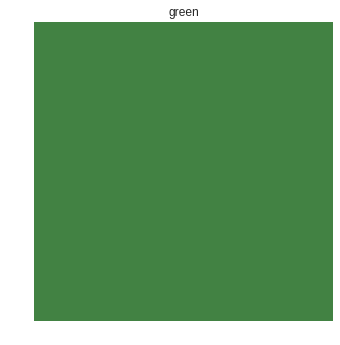

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Give me a color name (or press 'enter' to exit): 


<IPython.core.display.Javascript object>

In [22]:
def run_input_loop(sess, inference_ops, color_name_placeholder):
  """Helper function that reads from input and calls the inference ops in a loop."""

  tb = widgets.TabBar(["RNN Colorbot"])
  while True:
    with tb.output_to(0):
      try:
        color_name = six.moves.input("Give me a color name (or press 'enter' to exit): ")
      except (EOFError, KeyboardInterrupt):
        break
    if not color_name:
      break
    with tb.output_to(0):
      tb.clear_tab()
      sess.run(inference_ops, {color_name_placeholder: color_name})
      plt.show()

with tf.Graph().as_default():
  # Read the data.
  batch_size = 64
  train_data = load_dataset(data_dir, train_url, batch_size)
  eval_data = load_dataset(data_dir, test_url, 50, training=False)
  
  # Create the model components.
  lower_cell, upper_cell, relu_layer = model_components()
  # Create the helper placeholder for inference.
  color_name_placeholder = tf.placeholder(tf.string, shape=())
  
  # Compile the train / test code.
  tf_train_model = autograph.to_graph(train_model)
  train_model_ops = tf_train_model(
      train_data, eval_data, batch_size, lower_cell, upper_cell, relu_layer, train_steps=100)
  
  # Compile the inference code.
  tf_inference = autograph.to_graph(inference)
  inference_ops = tf_inference(color_name_placeholder, lower_cell, upper_cell, relu_layer)
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Run training and testing.
    sess.run(train_model_ops)
     
    # Run the inference loop.
    run_input_loop(sess, inference_ops, color_name_placeholder)

# Where do we go next?

Autograph is available in tensorflow.contrib, but it's still in its early stages. We're excited about the possibilities it brings — write your machine learning code in the flexible Eager style, but still enjoy all the benefits that come with running in graph mode. A beta version will be available soon -- stay tuned!